# Explore Training Curves

Modified by Jun, based on Patrick Coady's code: https://github.com/pat-coady/trpo

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

In [25]:
def find_moving_avg(data, window_size):
    quantile1 = np.zeros(len(data)-window_size)
    quantile2 = np.zeros(len(data)-window_size)
    avg = np.zeros(len(data)-window_size)
    for i in range(len(data)-window_size):
        avg[i] = np.mean(data[i:i+window_size])
        quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
        quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
    return avg, quantile1, quantile2

def df_plot(dfs, x, ys, isTaxi, isChain, isCliff, ylim=None, xlim=None, legend_loc='best'):
    """ Plot y vs. x curves from pandas dataframe(s)

    Args:
        dfs: list of pandas dataframes
        x: str column label for x variable
        ys: list of str column labels for y variable(s)
        ylim: tuple to override automatic y-axis limits
        xlim: tuple to override automatic x-axis limits
        legend_loc: str to override automatic legend placement:
            'upper left', 'lower left', 'lower right' , 'right' ,
            'center left', 'center right', 'lower center',
            'upper center', and 'center'
    """
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    for df, name in dfs:
        if '_' in name:
            name = name.split('_')[1]
            if 'KL' in name:
                name = 'DRTRPO-KL'
            else:
                name = 'DRTRPO-Wass'
        for y in ys:
            x_val = df[x]
            y_val = df[y]
            ws = 10
            if isTaxi == True:
                update_sz = 100
                plt.title('Taxi', fontsize = 22)
            if isChain == True:
                update_sz = 20
                plt.title('Chain', fontsize = 22)
            if isCliff == True:
                update_sz = 5
                plt.title('Cliff', fontsize = 22)
            moving_average = find_moving_avg(y_val, ws)
            plt.plot(x_val[0:len(x_val)-ws]/update_sz, moving_average[0], linewidth = 2.5, label=name)
            plt.fill_between(x_val[0:len(x_val)-ws]/update_sz, moving_average[1], moving_average[2], alpha=0.3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['axes.labelsize'] = 15
    plt.axis((None,None,None,None))
    plt.xlabel('Iteration')
    plt.ylabel('Rewards')

In [28]:
isTaxi = False
isChain = False
isCliff = True


# ENTER LIST OF LOG FILENAMES HERE:
if isTaxi:
    filepaths = ['log-files/Taxi-v3_DR-KL_Batch=100/Jan-07_21:08:22/log.csv', 'log-files/Taxi-v3_DR-Wass_Batch=100/Jan-07_21:52:54/log.csv']
if isChain:
    filepaths = ['log-files/NChain-v0_DR-KL_Batch=20/Jan-16_01:50:07/log.csv', 'log-files/NChain-v0_DR-Wass_Batch=15/Jan-16_07:06:11/log.csv']
if isCliff:
    filepaths = ['log-files/CliffWalking-v0_DR-KL_Batch=5/Feb-18_10:52:31/log.csv', 'log-files/CliffWalking-v0_DR-Wass_Batch=3/Feb-18_16:41:21/log.csv']

dataframes = []
names = []
for filepath in filepaths:
    names.append(filepath.split('/')[1])
    dataframes.append(pd.read_csv(filepath))
data = list(zip(dataframes, names))

# Plots

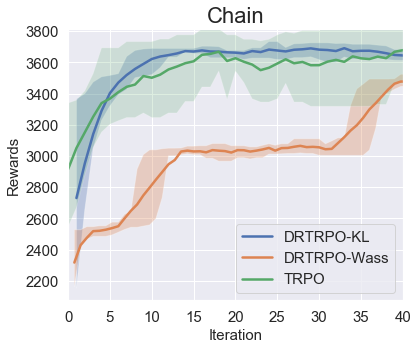

In [29]:
if isTaxi or isChain:
    df_plot(data, '_Episode', ['_AvgRewardSum'], isTaxi, isChain, isCliff, None, [0,40])
if isCliff:
    df_plot(data, '_Episode', ['_AvgRewardSum'], isTaxi, isChain, isCliff, None, [1,35])
    
# read TRPO baseline results
if isTaxi:
    trpo_log_name = './tmp/taxi_monitor.csv'
    trpo_update_sz = 5
if isChain:
    trpo_log_name = './tmp/chain_monitor.csv'
    trpo_update_sz = 1
if isCliff:
    trpo_log_name = './tmp/cliff_monitor.csv'
    trpo_update_sz = 1
    
    
window_size = 20
df=pd.read_csv(trpo_log_name, sep=',', skiprows = 0, header= 1)
y_val = df['r']
moving_average = find_moving_avg(y_val, window_size)
plt.plot(np.arange(len(y_val)-window_size)/trpo_update_sz, moving_average[0], label='TRPO', linewidth = 2.5)
plt.fill_between(np.arange(len(y_val)-window_size)/trpo_update_sz, moving_average[1], moving_average[2], alpha=0.2)
plt.legend(fontsize=15, loc='lower right')